In [1]:
from transformers import BertConfig
from gnn import GNNTrainer
from movie_lens_loader import MovieLensLoader
from llm import PromptBertClassifier, VanillaBertClassifier, AddingEmbeddingsBertClassifierBase, ClassifierBase

import itertools
import random as rd
from typing import List

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import DataLoader
import networkx as nx
from sklearn.decomposition import PCA

In [2]:
config = BertConfig.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
KGE_DIMENSION_PROMPT = 4
KGE_DIMENSION_ADDING = 128
KGE_DIMENSIONS = [KGE_DIMENSION_PROMPT, KGE_DIMENSION_ADDING] # Output Dimension of the GNN Encoder.
model_max_length = 256
movie_lens_loader = MovieLensLoader(kge_dimensions = KGE_DIMENSIONS)
gnn_trainer_prompt =    GNNTrainer(movie_lens_loader.data, kge_dimension = KGE_DIMENSION_PROMPT)
gnn_trainer_prompt.get_embeddings(movie_lens_loader)
gnn_trainer_adding =    GNNTrainer(movie_lens_loader.data, hidden_channels=KGE_DIMENSION_ADDING, kge_dimension = KGE_DIMENSION_ADDING)
gnn_trainer_adding.get_embeddings(movie_lens_loader)
vanilla_bert_only_classifier = VanillaBertClassifier(movie_lens_loader.llm_df,model_max_length = model_max_length)
dataset_vanilla = movie_lens_loader.generate_vanilla_dataset(vanilla_bert_only_classifier.tokenize_function)
prompt_bert_only_classifier = PromptBertClassifier(movie_lens_loader, gnn_trainer_prompt.get_embedding, kge_dimension=gnn_trainer_prompt.kge_dimension, batch_size=64,model_max_length = model_max_length)
dataset_prompt = movie_lens_loader.generate_prompt_embedding_dataset(prompt_bert_only_classifier.tokenize_function, kge_dimension = prompt_bert_only_classifier.kge_dimension)
adding_embedding_bert_only_classifier = AddingEmbeddingsBertClassifierBase(movie_lens_loader, gnn_trainer_adding.get_embedding, kge_dimension=config.hidden_size, batch_size=64,model_max_length = model_max_length)
dataset_adding_embedding = movie_lens_loader.generate_adding_embedding_dataset(adding_embedding_bert_only_classifier.tokenizer.sep_token, adding_embedding_bert_only_classifier.tokenizer.pad_token, adding_embedding_bert_only_classifier.tokenize_function, kge_dimension = config.hidden_size)

loading pretrained model
Device: 'cpu'
loading pretrained model
Device: 'cpu'


In [3]:
vanilla_pcas = vanilla_bert_only_classifier.init_pca(dataset_vanilla)
prompt_pcas = prompt_bert_only_classifier.init_pca(dataset_prompt)
embedding_pcas = adding_embedding_bert_only_classifier.init_pca(dataset_adding_embedding)



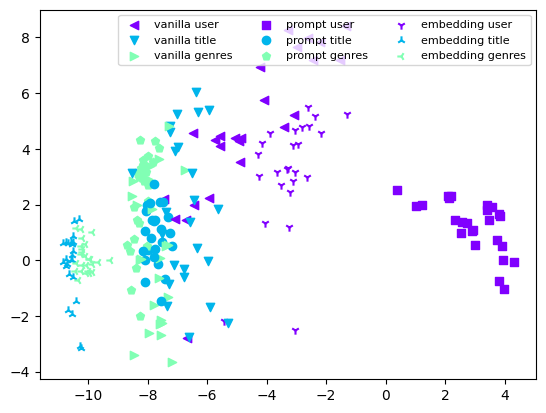

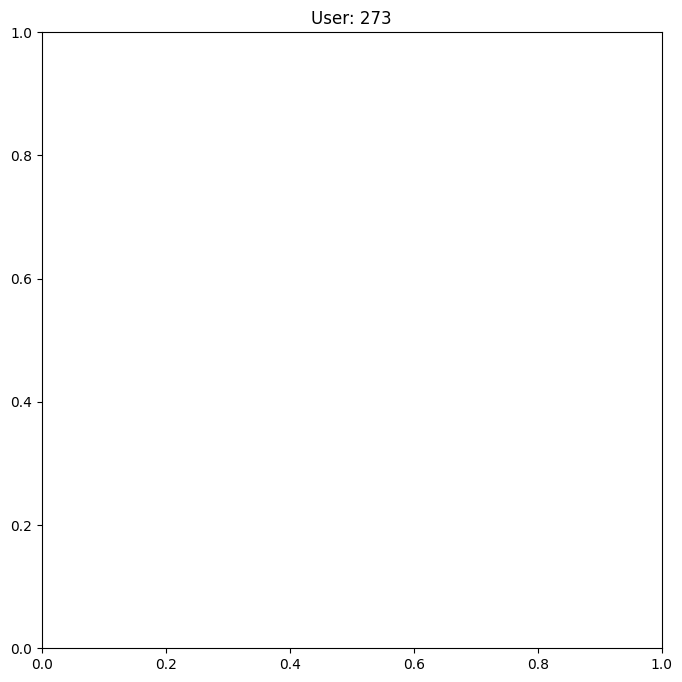

In [4]:
def plot_hidden_states_with_pca(vanilla_classifier, prompt_classifier, embedding_classifier, vanilla_pcas, prompt_pcas, embedding_pcas, prompt_getting_embedding_cb, embedding_getting_embedding_cb, n = 1, false_ratio = 0.7, plot_filters = ['vanilla user', 'vanilla title', 'vanilla genres', 'prompt user', 'prompt title', 'prompt genres', 'prompt user embedding', 'prompt movie embedding', 'embedding user', 'embedding title', 'embedding genres', 'embedding user embedding', 'embedding movie embedding'], singular_user = False, singular_title = False):
    vanilla_classifier.model.eval()
    prompt_classifier.model.eval()
    embedding_classifier.model.eval()
    samples = []
    all_low_dim_reps_vanilla,all_low_dim_reps_prompt, all_low_dim_reps_embedding = [], [], []
    for sample_num in range(n):
        existing = rd.uniform(0, 1) >=( 1 / (false_ratio + 1))
        sample_vanilla, sample_prompt, sample_embedding, random_row = movie_lens_loader.sample_datapoints(existing=existing, vanilla_classifier=vanilla_classifier, prompt_classifier=prompt_classifier, embedding_classifier=embedding_classifier, prompt_getting_embedding_cb = prompt_getting_embedding_cb, embedding_getting_embedding_cb = embedding_getting_embedding_cb, singular_user=singular_user, singular_title=singular_title)
        samples.append(random_row)
        with torch.no_grad():
            outputs_vanilla = vanilla_classifier.forward_batch(sample_vanilla, output_hidden_states = True)
            outputs_prompt = prompt_classifier.forward_batch(sample_prompt, output_hidden_states = True)
            outputs_embedding = embedding_classifier.forward_batch(sample_embedding, output_hidden_states = True)
            last_hidden_states_vanilla = outputs_vanilla.hidden_states[-1].squeeze()
            last_hidden_states_prompt = outputs_prompt.hidden_states[-1].squeeze()
            last_hidden_states_embedding = outputs_embedding.hidden_states[-1].squeeze()

            ranges_vanilla = vanilla_classifier._get_ranges_over_batch(sample_vanilla["input_ids"])[0]
            range_last_hidden_states_vanilla = torch.zeros((len(ranges_vanilla),last_hidden_states_vanilla.shape[-1]))
            for idx, range_borders in enumerate(ranges_vanilla):
                range_ = torch.arange(range_borders[0], range_borders[1])
                range_last_hidden_states_vanilla[idx] = torch.mean(last_hidden_states_vanilla[range_], dim=0)
            # Convert to numpy arrays
            range_last_hidden_states_vanilla = range_last_hidden_states_vanilla.detach().numpy()
            low_dim_reps_vanilla = []
            all_low_dim_reps_vanilla.append(low_dim_reps_vanilla)
            for pca, last_hidden_state in zip(vanilla_pcas, last_hidden_states_vanilla):
                low_dim_rep = pca.transform(last_hidden_state.unsqueeze(dim = 0))[0]
                low_dim_reps_vanilla.append(low_dim_rep)

            ranges_prompt = prompt_classifier._get_ranges_over_batch(sample_prompt["input_ids"])[0]
            range_last_hidden_states_prompt = torch.zeros((len(ranges_prompt),last_hidden_states_prompt.shape[-1]))
            for idx, range_borders in enumerate(ranges_prompt):
                range_ = torch.arange(range_borders[0], range_borders[1])
                range_last_hidden_states_prompt[idx] = torch.mean(last_hidden_states_prompt[range_], dim=0)
            # Convert to numpy arrays
            range_last_hidden_states_prompt = range_last_hidden_states_prompt.detach().numpy()
            low_dim_reps_prompt = []
            all_low_dim_reps_prompt.append(low_dim_reps_prompt)
            for pca, last_hidden_state in zip(prompt_pcas, last_hidden_states_prompt):
                low_dim_rep = pca.transform(last_hidden_state.unsqueeze(dim = 0))[0]
                low_dim_reps_prompt.append(low_dim_rep)

            ranges_embedding = embedding_classifier._get_ranges_over_batch(sample_embedding["input_ids"])[0]
            range_last_hidden_states_embedding = torch.zeros((len(ranges_embedding),last_hidden_states_embedding.shape[-1]))
            for idx, range_borders in enumerate(ranges_embedding):
                range_ = torch.arange(range_borders[0], range_borders[1])
                range_last_hidden_states_embedding[idx] = torch.mean(last_hidden_states_embedding[range_], dim=0)
            # Convert to numpy arrays
            range_last_hidden_states_embedding = range_last_hidden_states_embedding.detach().numpy()
            low_dim_reps_embedding = []
            all_low_dim_reps_embedding.append(low_dim_reps_embedding)
            for pca, last_hidden_state in zip(embedding_pcas, last_hidden_states_embedding):
                low_dim_rep = pca.transform(last_hidden_state.unsqueeze(dim = 0))[0]
                low_dim_reps_embedding.append(low_dim_rep)
    if singular_user:
        plt.title(f"User: {singular_user}")
    elif singular_title:
        plt.title(f"Title: {singular_title}")
    colors = cm.rainbow(np.linspace(0, 1, 5))
    for sample, low_dim_reps_vanilla, low_dim_reps_prompt, low_dim_reps_embedding in zip(samples, all_low_dim_reps_vanilla,all_low_dim_reps_prompt, all_low_dim_reps_embedding):
        user_id = sample["mappedUserId"]
        title = sample["title"]
        genres = sample["genres"]
        user_id_embedding_vanilla = low_dim_reps_vanilla[0]
        title_embedding_vanilla = low_dim_reps_vanilla[1]
        genres_embedding_vanilla = low_dim_reps_vanilla[2]

        scatter_legend = []
        if "vanilla user" in plot_filters:
            v_u = plt.scatter([user_id_embedding_vanilla[0]], [user_id_embedding_vanilla[1]], marker="<", color = colors[0])
            scatter_legend.append(v_u)
        if "vanilla title" in plot_filters:
            v_t = plt.scatter([title_embedding_vanilla[0]], [title_embedding_vanilla[1]], marker="v", color = colors[1])
            scatter_legend.append(v_t)
        if "vanilla genres" in plot_filters:
            v_g = plt.scatter([genres_embedding_vanilla[0]], [genres_embedding_vanilla[1]], marker=">", color = colors[2])
            scatter_legend.append(v_g)

        
        user_id_embedding_prompt = low_dim_reps_prompt[0]
        title_embedding_prompt = low_dim_reps_prompt[1]
        genres_embedding_prompt = low_dim_reps_prompt[2]
        user_embedding_embedding_prompt = low_dim_reps_prompt[3]
        movie_embedding_embedding_prompt = low_dim_reps_prompt[4]
        if "prompt user" in plot_filters:
            p_u = plt.scatter([user_id_embedding_prompt[0]], [user_id_embedding_prompt[1]], marker="s", color = colors[0])
            scatter_legend.append(p_u)
        if "prompt title" in plot_filters:
            p_t = plt.scatter([title_embedding_prompt[0]], [title_embedding_prompt[1]], marker="o", color = colors[1])
            scatter_legend.append(p_t)
        if "prompt genres" in plot_filters:
            p_g = plt.scatter([genres_embedding_prompt[0]], [genres_embedding_prompt[1]], marker="p", color = colors[2])
            scatter_legend.append(p_g)
        if "prompt user embedding" in plot_filters:
            p_ue = plt.scatter([user_embedding_embedding_prompt[0]], [user_embedding_embedding_prompt[1]], marker="P", color = colors[3])
            scatter_legend.append(p_ue)
        if "prompt movie embedding" in plot_filters:
            p_me = plt.scatter([movie_embedding_embedding_prompt[0]], [movie_embedding_embedding_prompt[1]], marker="*", color = colors[4])
            scatter_legend.append(p_me)
        
        
        user_id_embedding_embedding = low_dim_reps_embedding[0]
        title_embedding_embedding = low_dim_reps_embedding[1]
        genres_embedding_embedding = low_dim_reps_embedding[2]
        user_embedding_embedding_embedding = low_dim_reps_embedding[3]
        movie_embedding_embedding_embedding = low_dim_reps_embedding[4]
        if "embedding user" in plot_filters:
            e_u = plt.scatter([user_id_embedding_embedding[0]], [user_id_embedding_embedding[1]], marker="1", color = colors[0])
            scatter_legend.append(e_u)
        if "embedding title" in plot_filters:
            e_t = plt.scatter([title_embedding_embedding[0]], [title_embedding_embedding[1]], marker="2", color = colors[1])
            scatter_legend.append(e_t)
        if "embedding genres" in plot_filters:
            e_g = plt.scatter([genres_embedding_embedding[0]], [genres_embedding_embedding[1]], marker="3", color = colors[2])
            scatter_legend.append(e_g)
        if "embedding user embedding" in plot_filters:
            e_ue = plt.scatter([user_embedding_embedding_embedding[0]], [user_embedding_embedding_embedding[1]], marker="4", color = colors[3])
            scatter_legend.append(e_ue)
        if "embedding movie embedding" in plot_filters:
            e_me = plt.scatter([movie_embedding_embedding_embedding[0]], [movie_embedding_embedding_embedding[1]], marker="x", color = colors[4])
            scatter_legend.append(e_me)
    plt.legend(scatter_legend,
            plot_filters,
            scatterpoints=1,
            loc='upper right',
            ncol=3,
            fontsize=8,)
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
    plt.figure(figsize=(8, 8), dpi=100)
    plt.show()

    
n = 25
all_filters = ['vanilla user', 'vanilla title', 'vanilla genres', 'prompt user', 'prompt title', 'prompt genres', 'prompt user embedding', 'prompt movie embedding', 'embedding user', 'embedding title', 'embedding genres', 'embedding user embedding', 'embedding movie embedding']
only_user_filters = ['vanilla user', 'prompt user', 'embedding user']
only_title_filters = ['vanilla title', 'prompt title', 'embedding title']
only_genres_filters = ['vanilla genres', 'prompt genres', 'embedding genres']
user_title_filters = ['vanilla user', 'vanilla title', 'prompt user', 'prompt title', 'embedding user', 'embedding title']
embedding_filters = ['prompt user embedding', 'prompt movie embedding', 'embedding user embedding', 'embedding movie embedding']
vanilla_filters =  ['vanilla user', 'vanilla title', 'vanilla genres','prompt user', 'prompt title', 'prompt genres','embedding user', 'embedding title', 'embedding genres']
plot_filters = vanilla_filters
singular_user = True
singular_title = False
plot_hidden_states_with_pca(vanilla_bert_only_classifier, prompt_bert_only_classifier, adding_embedding_bert_only_classifier, vanilla_pcas, prompt_pcas, embedding_pcas, gnn_trainer_prompt.get_embedding, gnn_trainer_adding.get_embedding, n = n, plot_filters = plot_filters, singular_user=singular_user, singular_title=singular_title)